<h1><center><font size="6">Cats or Dogs - using CNN with Transfer Learning</font></center></h1>


<center><img src="https://www.theladders.com/wp-content/uploads/dog-cat-190709-1000x563.jpg" width="900"></img></center>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Load packages and set parameters</a>  
- <a href='#3'>Read the data</a>  
- <a href='#4'>Data exploration</a>
    - <a href='#41'>Class distribution</a>
    - <a href='#42'>Images samples</a>
- <a href='#5'>Model</a>  
    - <a href='#51'>Prepare the model</a>  
    - <a href='#52'>Train the model</a>  
    - <a href='#53'>Validation accuracy and loss</a>  
    - <a href='#54'>Validation accuracy per class</a>  
- <a href='#6'>Prepare submission</a>     
- <a href='#7'>Conclusions</a>
- <a href='#8'>References</a>



# <a id="1">Introduction</a>  


## Dataset

The **train** folder contains **25,000** images of **dogs** and **cats**. Each image in this folder has the label as part of the filename. The **test** folder contains **12,500** images, named according to a numeric id.  
For each image in the test set, you should predict a probability that the image is a dog (**1** = **dog**, **0** = **cat**).


## Method

For the solution of this problem we will use a pre-trained model, ResNet-50, replacing only the last layer.

# <a id="2">Load packages</a>

In [3]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
%matplotlib inline 

Using TensorFlow backend.


## Parameters

Here we set few parameters used in the model. The image size is **224**.    
The images are stored in two folders, **train** and **test**.  
There are two image classes: **Dog** and **Cat**.  
We will use a subset of the training data set (**20,000** images).  From the training set, **50%** will be used for training, **50%** for validation.  
A pre-trained model from **ResNet-50** will be used.  
A number of **10** epochs will be used for training.  



In [4]:
TEST_SIZE = 0.5
RANDOM_STATE = 2018
BATCH_SIZE = 64
NO_EPOCHS = 20
NUM_CLASSES = 2
SAMPLE_SIZE = 20000
PATH = '/kaggle/input/competitions/dogs-vs-cats-redux-kernels-edition/'
TRAIN_FOLDER = './train/'
TEST_FOLDER =  './test/'
IMG_SIZE = 224
RESNET_WEIGHTS_PATH = '/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [5]:
import os
print(os.listdir("/kaggle/input"))


['competitions', 'resnet50']


In [6]:
import zipfile

# Extract train.zip
with zipfile.ZipFile('/kaggle/input/competitions/dogs-vs-cats-redux-kernels-edition/train.zip', 'r') as z:
    z.extractall('/kaggle/working/')

# Extract test.zip
with zipfile.ZipFile('/kaggle/input/competitions/dogs-vs-cats-redux-kernels-edition/test.zip', 'r') as z:
    z.extractall('/kaggle/working/')

print("Extraction complete")


Extraction complete


In [7]:
import os

print("Train images:", len(os.listdir('/kaggle/working/train')))
print("Test images:", len(os.listdir('/kaggle/working/test')))


Train images: 25000
Test images: 12500


# <a id="3">Read the data</a>

We set the train image list.   
Setting the **SAMPLE_SIZE** value we can reduce/enlarge the size of the training set.    
Currently **SAMPLE_SIZE** is set to **20,000**.


In [8]:
import os
os.makedirs("./train", exist_ok=True)
os.makedirs("./test", exist_ok=True)
print("Folders created")


Folders created


In [9]:
import zipfile

train_zip = PATH + "train.zip"

with zipfile.ZipFile(train_zip, "r") as z:
    z.extractall("./train")

print("Train extracted")


Train extracted


In [10]:
test_zip = PATH + "test.zip"

with zipfile.ZipFile(test_zip, "r") as z:
    z.extractall("./test")

print("Test extracted")


Test extracted


In [11]:
import os
import shutil

train_dir = "/kaggle/working/train"

cats_dir = os.path.join(train_dir, "cats")
dogs_dir = os.path.join(train_dir, "dogs")

os.makedirs(cats_dir, exist_ok=True)
os.makedirs(dogs_dir, exist_ok=True)

for filename in os.listdir(train_dir):
    file_path = os.path.join(train_dir, filename)

    if os.path.isdir(file_path):
        continue

    if filename.startswith("cat"):
        shutil.move(file_path, os.path.join(cats_dir, filename))
    elif filename.startswith("dog"):
        shutil.move(file_path, os.path.join(dogs_dir, filename))

print("Images sorted into cats and dogs folders.")


Images sorted into cats and dogs folders.


In [12]:
import os
print("Train:", len(os.listdir("./train")))
print("Test:", len(os.listdir("./test")))


Train: 3
Test: 12501


In [13]:
train_image_list = os.listdir("./train/train/")[0:SAMPLE_SIZE]
test_image_list = os.listdir("./test/test/")


We set a function for parsing the image names to extract the first 3 letters from the image names, which gives the label of the image. It will be either a cat or a dog. We are using one hot encoder, storing [1,0] for **cat** and [0,1] for **dog**.

In [14]:
def label_pet_image_one_hot_encoder(img):
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]

We are defining as well a function to process the data (both train and test set). 

In [15]:
def label_pet_image_one_hot_encoder(img):
    pet = img.split('.')[-3]
    if pet == 'cat': 
        return [1,0]
    elif pet == 'dog': 
        return [0,1]


# <a id="4">Data exploration</a>


## <a id="41">Class distribution</a>

Let's inspect the train data to check the **cat**/**dog** distribution.   We show first the split in the reduced train data.

In [16]:
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER, img)
        
        if isTrain:
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        
        img_data = cv2.imread(path, cv2.IMREAD_COLOR)
        
        if img_data is None:
            continue
        
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        data_df.append([np.array(img_data), np.array(label)])
    
    shuffle(data_df)
    return data_df



In [17]:
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[-3])
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.countplot(x=labels)
    plt.title('Cats and Dogs')
    plt.show()

Let's show also the class distribution in the full train data set.

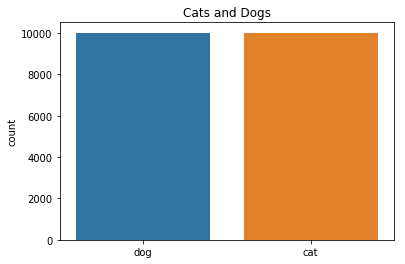

In [18]:
plot_image_list_count(train_image_list)



In [19]:
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[-3])
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.countplot(x=labels)
    plt.title('Cats and Dogs')
    plt.show()

## <a id="42">Images samples</a>

Let's represet some of the images. We start with a selection from the train set. We will show the first 25 images from the train set.

First,  we process the train data, reading the images and creating a table with images and labels. If the data is trom train set, the label is the one calculated with one hot encoding; if the data is from test set, the label will be the image number.

In [20]:
train = process_data(train_image_list, "./train/train/")


100%|██████████| 20000/20000 [00:52<00:00, 378.02it/s]


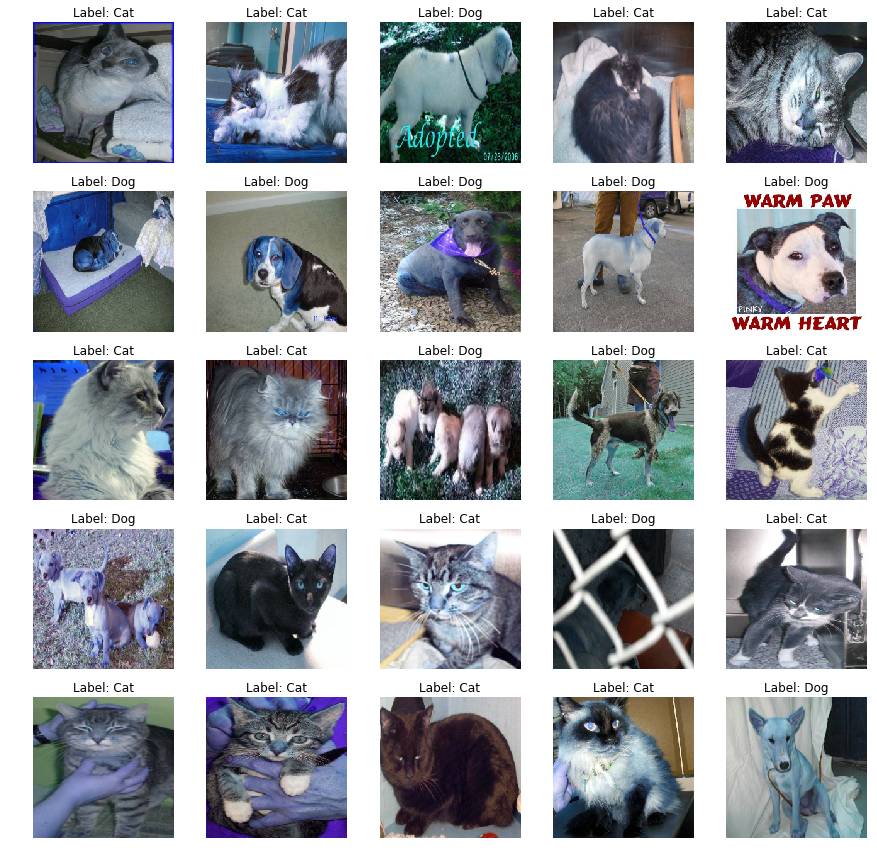

In [23]:
show_images(train)


Then, we plot the image selection.

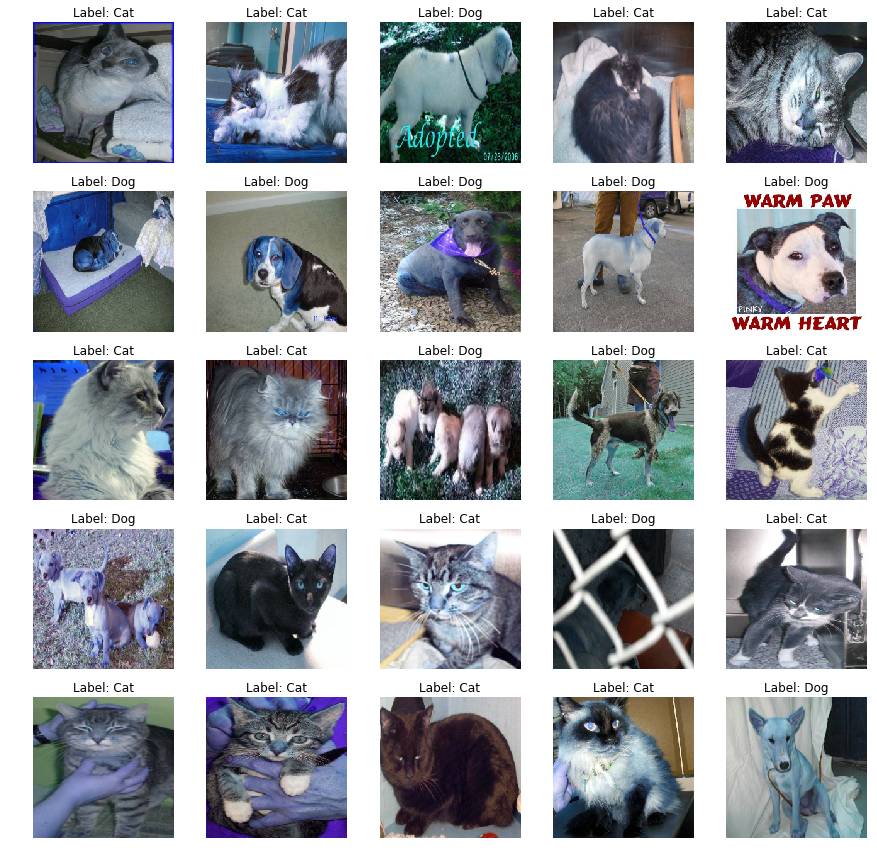

In [22]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(train)

Let's also show a selection of the train set. We prepare the test set.

In [24]:
test = process_data(test_image_list, TEST_FOLDER, False)

100%|██████████| 12500/12500 [00:32<00:00, 379.52it/s]


Then, we show a selection of the test set.

In [25]:
print(len(test_image_list))
print(test_image_list[:10])


12500
['1808.jpg', '7044.jpg', '6013.jpg', '2697.jpg', '1113.jpg', '4267.jpg', '8798.jpg', '790.jpg', '5747.jpg', '11376.jpg']


In [26]:
print(len(test))


12500


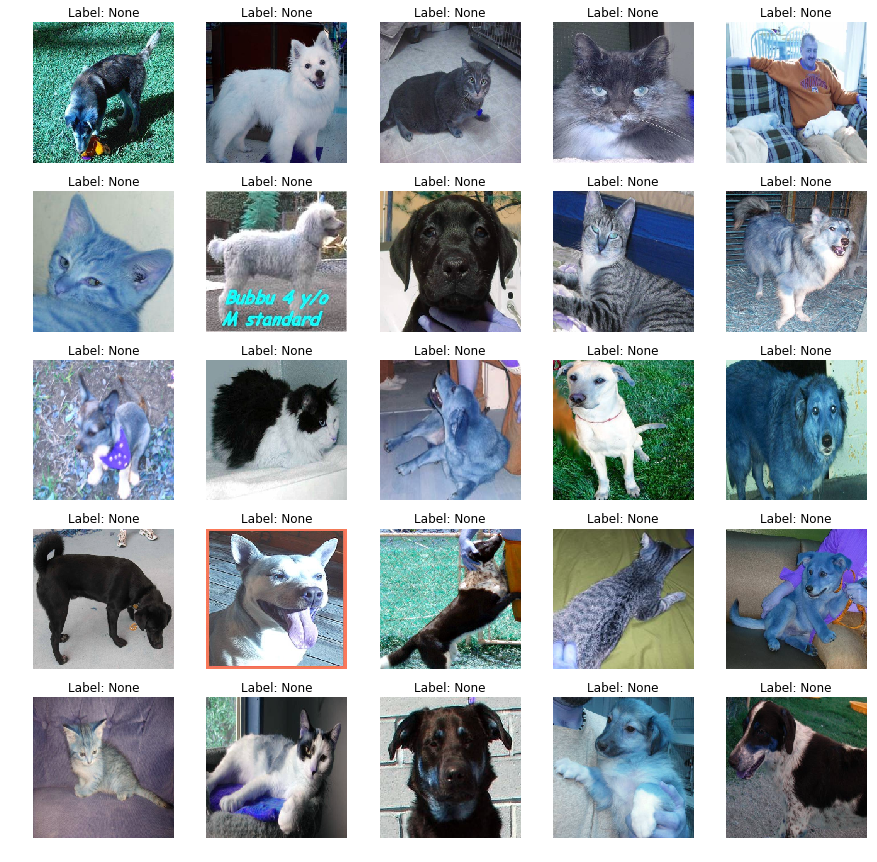

In [28]:
show_images(test,True)

In [27]:
import os
print("Train folder:", os.listdir(TRAIN_FOLDER)[:5])
print("Test folder:", os.listdir(TEST_FOLDER)[:5])



Train folder: ['dogs', 'cats', 'train']
Test folder: ['1808.jpg', '7044.jpg', '6013.jpg', '2697.jpg', '1113.jpg']


In [28]:
import shutil
import os

extra_folder = os.path.join(TRAIN_FOLDER, "train")

if os.path.exists(extra_folder):
    shutil.rmtree(extra_folder)
    print("Extra train folder removed.")
else:
    print("No extra folder found.")


Extra train folder removed.


In [29]:
import os
print("Train folder:", os.listdir(TRAIN_FOLDER))



Train folder: ['dogs', 'cats']


In [30]:
import os
import shutil

train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test"

# Create class folders
for folder in ["cats", "dogs"]:
    os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, folder), exist_ok=True)

# Sort train images
for filename in os.listdir(train_dir):
    file_path = os.path.join(train_dir, filename)

    if os.path.isdir(file_path):
        continue

    if filename.startswith("cat"):
        shutil.move(file_path, os.path.join(train_dir, "cats", filename))
    elif filename.startswith("dog"):
        shutil.move(file_path, os.path.join(train_dir, "dogs", filename))

print("Train images organized.")


Train images organized.


In [31]:
import os
import shutil

source_dir = "/kaggle/working/train"
cats_dir = "/kaggle/working/train/cats"
dogs_dir = "/kaggle/working/train/dogs"

os.makedirs(cats_dir, exist_ok=True)
os.makedirs(dogs_dir, exist_ok=True)

for filename in os.listdir(source_dir):
    file_path = os.path.join(source_dir, filename)

    # Skip directories (like cats and dogs folders)
    if os.path.isdir(file_path):
        continue

    if filename.startswith("cat"):
        shutil.move(file_path, os.path.join(cats_dir, filename))
    elif filename.startswith("dog"):
        shutil.move(file_path, os.path.join(dogs_dir, filename))

print("Files organized into cats and dogs folders.")



Files organized into cats and dogs folders.


# <a id="5">Model</a>

## <a id="51">Prepare the model</a>

Let's start by preparing the model.

### Prepare the train data

In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image settings
IMG_SIZE = 150
BATCH_SIZE = 32

# Data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training data
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Validation data
val_generator = train_datagen.flow_from_directory(
    '/kaggle/working/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [33]:
X = np.array([i[0] for i in train])
y = np.array([i[1] for i in train])


In [34]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (20000, 224, 224, 3)
y shape: (20000, 2)


### Prepare the model

We initialize the **ResNet-50** model, adding an additional last layer of type **Dense**, with **softmax** activation function.   

We also set the first layer of the model to be not trainable, becaise **ResNet-50** model was already trained.

In [35]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights=RESNET_WEIGHTS_PATH))
model.add(Dense(NUM_CLASSES, activation='softmax'))

# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = False


In [36]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [47]:
history = model.fit(X, y, epochs=2, batch_size=32)


Epoch 1/2
20000/20000 [==============================] - 3399s 170ms/step - loss: 8.0478 - acc: 0.5007
Epoch 2/2
20000/20000 [==============================] - 3404s 170ms/step - loss: 8.0478 - acc: 0.5007


In [48]:
model.save("cats_dogs_model.h5")
print("Model saved successfully")


Model saved successfully


### Compile the model

We compile the model, using a **sigmoid** optimized, the loss function as **categorical crossentropy** and the metric **accuracy**.

In [38]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

### Model summary

We plot the model description. We can see that the **ResNet-50** model represent the 1st layer of our model, of type **Model**.

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


Let's also show the model graphical representation using **plot_model**.

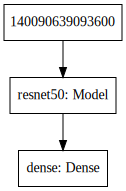

In [40]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Split the train data in train and validation

We split the train data in two parts. One will be reserved for train set, the second for validation set. Only the train subset of the data will be used for training the model; the validation set will be used for validation, during training.

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## <a id="52">Train the model</a>

We are now ready to train our model.

## <a id="53">Validation accuracy and loss</a>

Let's show the train and validation accuracy on the same plot. As well, we will represent the train and validation loss on the same graph.

Let's also show the numeric validation accuracy and loss.

In [ ]:
loss, acc = model.evaluate(X, y)
print("Final Accuracy:", acc)


## <a id="54">Validation accuracy per class</a>

Let's show the validation accuracy per each class.

We start by predicting the labels for the validation set.

In [ ]:
history = model.fit(X, y, epochs=2, batch_size=32)

plt.plot(history.history['accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


Epoch 1/2
20000/20000 [==============================] - 3450s 172ms/step - loss: 8.0478 - acc: 0.5007
Epoch 2/2
16128/20000 [=======================>......] - ETA: 11:14 - loss: 8.1340 - acc: 0.4953

We create two indices, **correct** and **incorrect**, for the images in the validation set with class predicted correctly and incorrectly, respectively.


We saw what is the number of correctly vs. incorrectly predicted values in the validation set.    

We show here the classification report for the validation set, with the accuracy per class and overall.

# <a id="6">Prepare the submission</a>

### Show test images with predicted class

Let's show few of the test images with the predicted class. For this, we will have to predict the class.


### Test data prediction

### Submission file

Let's prepare now the submission file.

In [48]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission.csv", index=False)

In [49]:
import os
print(os.listdir("/kaggle/working"))


['model.png', 'train', 'cats_dogs_model.h5', 'submission.csv', 'test']


# <a id="7">Conclusions</a>

Using a pretrained model for Keras, ResNet-50, with a Dense model with softmax activation added on top and training with a reduced set of  we were able to obtain quite good model in terms of validation accuracy.   
The model was used to predict the classes of the images from the independent test set and results were submitted to test the accuracy of the prediction with fresh data.  


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()


In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.legend()
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
loss, acc = model.evaluate(X, y)
print("Final Accuracy:", acc)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predictions
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


# <a id="8">References</a>

[1] Dogs vs. Cats Redux: Kernels Edition, https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition  
[2] ResNet pretrained models for Keras, https://www.kaggle.com/keras/resnet50  



